In [1]:
from lxml import etree
import re
import math
import numpy as np
import pandas as pd
from pprint import pprint
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
%matplotlib inline

In [2]:
class Text(BaseEstimator, TransformerMixin): 
    def __init__(self, lenMin=2000, lenMax=10000, chunks=False): 
        self.lenMin = lenMin
        self.lenMax = lenMax
        self.chunks=chunks
        
    def fit(self, *_):
        print('heyo! fitting')
        return self

    def transform(self, filename): 
        print('heyo! transforming')
        lenMin, lenMax = self.lenMin, self.lenMax
        self.tree = etree.parse(filename)
        self.allSaidElems = self.tree.findall('.//said[@who]')
        # Only get those in our length range
        self.saidElems = [elem for elem in self.allSaidElems if len(elem.text)>lenMin and len(elem.text)<lenMax]
        self.allChars = [elem.attrib['who'] for elem in self.saidElems]
        self.chars = list(set(self.allChars))
        self.labeledText = [(elem.attrib['who'], elem.text) for elem in self.saidElems]
        self.labeledText = [(item[0], self.clean(item[1])) for item in self.labeledText]
        self.labels = [item[0] for item in self.labeledText]
        charDict = {'Bernard': 0, 'Louis': 1, 'Neville': 2,
                'Rhoda': 3, 'Jinny': 4, 'Susan': 5}
        self.numericLabels = [charDict[label] for label in self.labels]
        self.allText = [item[1] for item in self.labeledText]
        self.charDict = self.makeCharDict()
        self.charChunks, self.charChunksLabels = self.makeCharChunks()
        if self.chunks: 
            self.allText = self.charChunks
            self.labels = self.charChunksLabels
            self.numericLabels = [charDict[label.split('-')[0]] for label in self.labels]
        self.lengths = [len(item) for item in self.allText]
        return self.allText
        
    def makeCharDict(self): 
        """ Make a dictionary of each character's total speech. """
        # Initialize empty dictionary. 
        charDict = {char: "" for char in self.chars}
        for elem in self.allSaidElems: 
            charDict[elem.attrib['who']]+=self.clean(elem.text)
        return charDict
            
    def makeCharChunks(self, n=2): 
        """ Make a list of chunks of character speech. """
        charChunks = []
        charChunksLabels = []
        for char, text in self.charDict.items(): 
            chunks = self.sliceText(text)
            for i, chunk in enumerate(chunks): 
                charChunks.append(chunk)
                charChunksLabels.append(char + '-%s' % i)
        return charChunks, charChunksLabels
        
    def sliceText(self, text, size=8000):
        parts = []
        while len(text) > size: 
            part = text[:size]
            text = text[size:]
            parts.append(part)
        return parts

    def clean(self, utterance): 
        """ 
        Cleans utterances. 
        """
        # Remove "said Bernard," etc. 
        charRegex = "said (%s)" % '|'.join(self.chars)
        out = re.sub(charRegex, '', utterance)
       
        # Remove quotation marks. 
        out = re.sub('[“”"]', '', out)
        
        # Remove line breaks. 
        out = re.sub('\n', ' ', out)
        return out

In [3]:
# Code adapted from http://stackoverflow.com/a/28384887/584121
class DenseTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self): 
        return

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [4]:
text = Text().fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels

heyo! fitting
heyo! transforming


In [5]:
len(docs), len(labels)

(45, 45)

In [6]:
def verboseGridSearch(pipeline, parameters, docs, labels): 
    scorer = metrics.make_scorer(metrics.adjusted_rand_score)    
    grid_search = GridSearchCV(pipeline, parameters, scoring=scorer, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(docs, labels)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [7]:
pipeline = Pipeline([  
#                          ('text', Text()), 
                         ('tfidf', TfidfVectorizer()),
                         ('todense', DenseTransformer()),
                         ('pca', PCA()),
                         ('bgm', BayesianGaussianMixture()),
                        ])

# Test 1A
Uses the default lenMin=2000, lenMax=10000, chunks=False.

In [8]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
    'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.5, 0.7, 1.0),
    'tfidf__max_features': (100, 200, 500, 1000, 2000), 
    'pca__n_components': (2, 5, 10, 20, 30, 50),
    'bgm__n_components': (2, 4, 6)
             }

verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (2, 4, 6),
 'pca__n_components': (2, 5, 10, 20, 30, 50),
 'tfidf__max_df': (0.5, 0.7, 1.0),
 'tfidf__max_features': (100, 200, 500, 1000, 2000),
 'tfidf__min_df': (0.0, 0.3, 0.4)}
Fitting 3 folds for each of 810 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   55.3s
/usr/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 1573 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2023 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  3.1min finished


done in 184.280s

Best score: 0.246
Best parameters set:
	bgm__n_components: 4
	pca__n_components: 5
	tfidf__max_df: 0.5
	tfidf__max_features: 200
	tfidf__min_df: 0.0


# Test 1B

In [11]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.2, 0.3, 0.4, 0.5, 0.6),
    'tfidf__max_features': (100, 200, 500, 1000, 10000, 100000), 
    'pca__n_components': (5, 10, 20, 25, 50),
    'bgm__n_components': (2, 4, 6, 8)
             }
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (2, 4, 6, 8),
 'pca__n_components': (5, 10, 20, 25, 50),
 'tfidf__max_df': (0.2, 0.3, 0.4, 0.5, 0.6),
 'tfidf__max_features': (100, 200, 500, 1000, 10000, 100000)}
Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min


done in 132.883s

Best score: 0.246
Best parameters set:
	bgm__n_components: 8
	pca__n_components: 5
	tfidf__max_df: 0.3
	tfidf__max_features: 500


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  2.2min finished


# Test 1C

In [12]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.2, 0.3, 0.4, 1),
    'tfidf__max_features': (200, 500, 1000, None), 
    'pca__n_components': (2, 5, 25, 35),
    'bgm__n_components': (2, 4, 6, 8)
             }
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (2, 4, 6, 8),
 'pca__n_components': (2, 5, 25, 35),
 'tfidf__max_df': (0.2, 0.3, 0.4, 1),
 'tfidf__max_features': (200, 500, 1000, None)}
Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:   51.8s finished


done in 52.284s

Best score: 0.202
Best parameters set:
	bgm__n_components: 8
	pca__n_components: 25
	tfidf__max_df: 0.4
	tfidf__max_features: None


# Test 1D

In [14]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
    'tfidf__min_df': (0.0, 1),
    'tfidf__max_df': (0.2, 0.3, 0.4, 1.0),
    'tfidf__max_features': (200, 500, 1000, None), 
    'pca__n_components': (2, 5, 25, 35, 50),
    'bgm__n_components': (2, 4, 6, 8, 10)
             }
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (2, 4, 6, 8, 10),
 'pca__n_components': (2, 5, 25, 35, 50),
 'tfidf__max_df': (0.2, 0.3, 0.4, 1.0),
 'tfidf__max_features': (200, 500, 1000, None),
 'tfidf__min_df': (0.0, 1)}
Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.9min
/usr/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  3.0min finished


done in 180.993s

Best score: 0.263
Best parameters set:
	bgm__n_components: 8
	pca__n_components: 25
	tfidf__max_df: 0.4
	tfidf__max_features: None
	tfidf__min_df: 1


# Test 2A
Tested with the full range of utterances (lenMin=0, lenMax=a lot, chunks=False).

In [15]:
text = Text(lenMin=0, lenMax=1000000000).fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels

heyo! fitting
heyo! transforming


In [16]:
len(docs), len(labels)

(240, 240)

In [17]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
#     'tfidf__max_df': (0.5, 0.7, 1.0),
    'tfidf__max_features': (100, 500, 1000, None), 
    'pca__n_components': (2, 5, 25, 30),
    'bgm__n_components': (6, 8, 10)
             }
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (6, 8, 10),
 'pca__n_components': (2, 5, 25, 30),
 'tfidf__max_features': (100, 500, 1000, None)}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
/usr/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init 

done in 33.459s

Best score: 0.025
Best parameters set:
	bgm__n_components: 8
	pca__n_components: 5
	tfidf__max_features: 500


# Test 3A
Testing with a min length of 2000, a large max length, and chunking. 

In [18]:
text = Text(lenMin=2000, lenMax=1000000000000, chunks=True).fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels

heyo! fitting
heyo! transforming


In [19]:
len(docs), len(labels)

(44, 44)

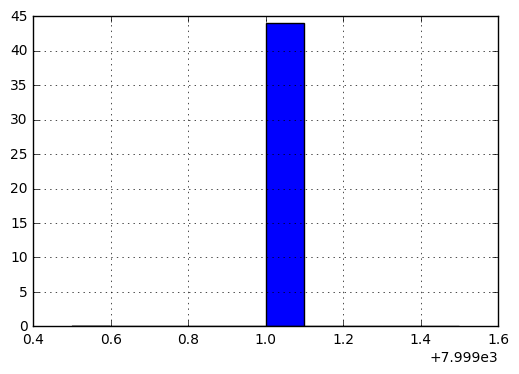

In [21]:
pd.Series([len(text) for text in docs]).hist()

In [22]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
#     'tfidf__max_df': (0.5, 0.7, 1.0),
    'tfidf__max_features': (100, 500, 1000, None), 
    'pca__n_components': (2, 5, 25, 30),
    'bgm__n_components': (6, 8, 10)
             }
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (6, 8, 10),
 'pca__n_components': (2, 5, 25, 30),
 'tfidf__max_features': (100, 500, 1000, None)}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   15.8s finished


done in 16.150s

Best score: 0.221
Best parameters set:
	bgm__n_components: 6
	pca__n_components: 5
	tfidf__max_features: 500


# Test 4

heyo! fitting
heyo! transforming


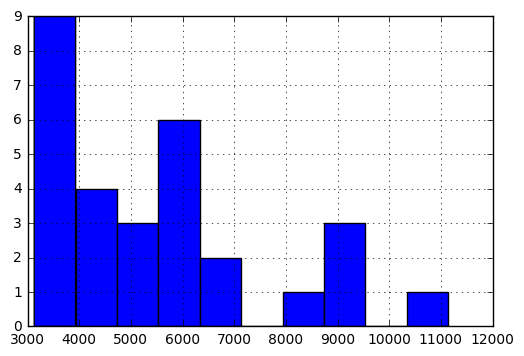

In [27]:
text = Text(lenMin=3000, lenMax=20000).fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels
pd.Series([len(text) for text in docs]).hist()

In [28]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
#     'tfidf__max_df': (0.5, 0.7, 1.0),
    'tfidf__max_features': (10000, 20000, 50000, None), 
    'pca__n_components': (25, 30, 35),
    'bgm__n_components': (6, 8, 10)
             }

In [29]:
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (6, 8, 10),
 'pca__n_components': (25, 30, 35),
 'tfidf__max_features': (10000, 20000, 50000, None)}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.1s


done in 6.257s

Best score: 0.107
Best parameters set:
	bgm__n_components: 8
	pca__n_components: 35
	tfidf__max_features: None


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    6.0s finished


# Test 5

heyo! fitting
heyo! transforming


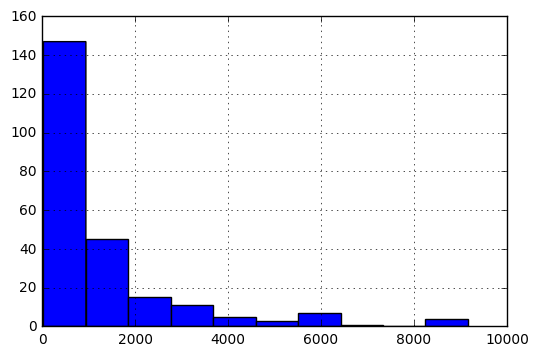

In [31]:
text = Text(lenMin=0, lenMax=10000).fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels
pd.Series([len(text) for text in docs]).hist()

In [32]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
#     'tfidf__max_df': (0.5, 0.7, 1.0),
    'tfidf__max_features': (10000, 20000, 50000, None), 
    'pca__n_components': (25, 30, 35),
    'bgm__n_components': (6, 8, 10)
             }

In [33]:
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (6, 8, 10),
 'pca__n_components': (25, 30, 35),
 'tfidf__max_features': (10000, 20000, 50000, None)}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   42.6s finished


done in 43.701s

Best score: 0.020
Best parameters set:
	bgm__n_components: 10
	pca__n_components: 25
	tfidf__max_features: 20000


# Test 6

heyo! fitting
heyo! transforming


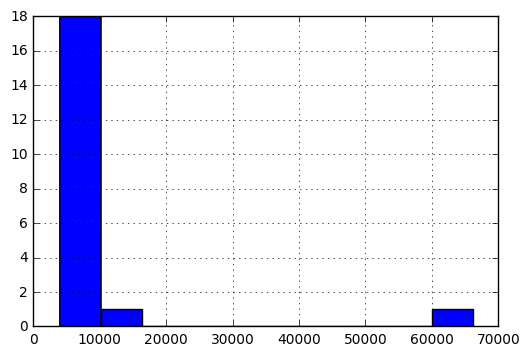

In [34]:
text = Text(lenMin=4000, lenMax=10000000000).fit()
docs = text.tr10000010000010000000000rm('waves-tei.xml')
labels = text.numericLabels
pd.Series([len(text) for text in docs]).hist()

In [35]:
len(docs)

20

In [36]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
#     'tfidf__max_df': (0.5, 0.7, 1.0),
    'tfidf__max_features': (10000, 20000, 50000, None), 
    'pca__n_components': (25, 30, 35),
    'bgm__n_components': (6, 8, 10)
             }

In [37]:
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (6, 8, 10),
 'pca__n_components': (25, 30, 35),
 'tfidf__max_features': (10000, 20000, 50000, None)}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 101 out of 108 | elapsed:    4.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    4.6s finished


done in 4.826s

Best score: 0.114
Best parameters set:
	bgm__n_components: 8
	pca__n_components: 35
	tfidf__max_features: 20000


# Test 7

heyo! fitting
heyo! transforming


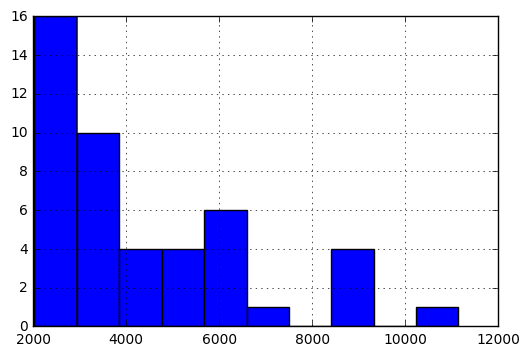

In [39]:
text = Text(lenMin=2000, lenMax=50000).fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels
pd.Series([len(text) for text in docs]).hist()

In [40]:
len(docs)

46

In [41]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.3, 0.4, 0.5, 1.0),
    'tfidf__max_features': (100, 500, 5000, None), 
    'pca__n_components': (2, 5, 25, 35),
    'bgm__n_components': (2, 6, 8, 10)
             }

In [42]:
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (2, 6, 8, 10),
 'pca__n_components': (2, 5, 25, 35),
 'tfidf__max_df': (0.3, 0.4, 0.5, 1.0),
 'tfidf__max_features': (100, 500, 5000, None)}
Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:   57.1s finished


done in 57.484s

Best score: 0.257
Best parameters set:
	bgm__n_components: 10
	pca__n_components: 25
	tfidf__max_df: 0.5
	tfidf__max_features: 5000


# Test 8

heyo! fitting
heyo! transforming


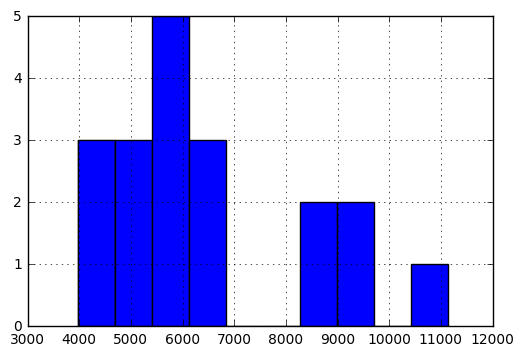

In [43]:
text = Text(lenMin=4000, lenMax=20000).fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels
pd.Series([len(text) for text in docs]).hist()

In [44]:
len(docs)

19

In [45]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.3, 0.4, 0.5, 1.0),
    'tfidf__max_features': (100, 500, 5000, None), 
    'pca__n_components': (2, 5, 25, 35),
    'bgm__n_components': (2, 6, 8, 10)
             }

In [46]:
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (2, 6, 8, 10),
 'pca__n_components': (2, 5, 25, 35),
 'tfidf__max_df': (0.3, 0.4, 0.5, 1.0),
 'tfidf__max_features': (100, 500, 5000, None)}
Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   14.6s


done in 35.506s

Best score: 0.302
Best parameters set:
	bgm__n_components: 8
	pca__n_components: 5
	tfidf__max_df: 0.3
	tfidf__max_features: 500


[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:   35.3s finished


# Test 9

In [50]:
parameters = {  
#     'text__lenMin': (2000, 3000),
#     'text__lenMax': (20000, 2000000),
#     'tfidf__use_idf': (True, False), 
#     'tfidf__min_df': (0.0, 0.3, 0.4),
    'tfidf__max_df': (0.1, 0.2, 0.3, 0.4, 1.0),
    'tfidf__max_features': (100, 400, 500, 5000, None), 
    'pca__n_components': (2, 4, 5, 25, 35),
    'bgm__n_components': (2, 6, 8, 10)
             }

In [51]:
verboseGridSearch(pipeline, parameters, docs, labels)

Performing grid search...
pipeline: ['tfidf', 'todense', 'pca', 'bgm']
parameters:
{'bgm__n_components': (2, 6, 8, 10),
 'pca__n_components': (2, 4, 5, 25, 35),
 'tfidf__max_df': (0.1, 0.2, 0.3, 0.4, 1.0),
 'tfidf__max_features': (100, 400, 500, 5000, None)}
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   38.6s


done in 70.468s

Best score: 0.425
Best parameters set:
	bgm__n_components: 8
	pca__n_components: 5
	tfidf__max_df: 0.3
	tfidf__max_features: 500


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.2min finished
